In [1]:
import time
import tqdm

import pandas as pd

import pennylane as qml

import torch
import torch.nn as nn
import torch.nn.functional as F

from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler

from matplotlib import pyplot as plt

plt.style.use("dark_background")

### Functions

In [2]:
def fit(model, loss_function, optimizer, fields, targets):

    model.train()

    predictions = model(fields)

    loss = loss_function(predictions, targets.float())

    model.zero_grad()

    loss.backward()

    optimizer.step()

    return loss.item()


def predict(model, fields):

    model.eval()

    with torch.no_grad():

        if not isinstance(fields, torch.Tensor):

            fields = torch.tensor(fields)

        predictions = model(fields).numpy()

    return predictions


def batch_predict(model, data_loader):

    targets = []
    predictions = []

    for fields, target in data_loader:

        prediction = predict(model, fields)

        targets.extend(target.tolist())
        predictions.extend(prediction.tolist())

    score = r2_score(targets, predictions)

    return predictions, score


def train(x_train, y_train, 
          x_test, y_test, 
          model,
          epochs=50,
          batch_size=8,
          learning_rate=0.001, 
          weight_decay=1e-6,
          printout_period=1):
    
    start_time = time.time()
    
    records_count = len(x_train)

    batches = records_count // batch_size
    
    # loss_function = nn.MSELoss()
    
    loss_function = nn.BCELoss()
    
    optimizer = torch.optim.Adam(params=model.parameters(), 
                                 lr=learning_rate,
                                 weight_decay=weight_decay)
    
    data_loader_train = torch.utils.data.DataLoader(
        list(zip(x_train, y_train)), 
        batch_size=batch_size, shuffle=True, drop_last=True
    )
    
    data_loader_test = torch.utils.data.DataLoader(
        list(zip(x_test, y_test)), 
        batch_size=batch_size, shuffle=True, drop_last=True
    )
    
    best_model = model
    best_avg_train_loss = 0
    best_avg_test_loss = 0
    
    train_losses = []
    test_losses = []
        
    total_records_count = epochs * records_count
    
    fit_batch_tracker = tqdm.trange(
        total_records_count,
        unit=' records',
        unit_scale=True,
        ncols=90,
        mininterval=1
    )
    
    for epoch in range(epochs):
        
        fit_batch_tracker.set_description(f"Epoch: {epoch + 1}")
               
        epoch_train_loss = 0
        
        for xs, ys in data_loader_train:
                   
            loss_evaluated = fit(model, loss_function, optimizer, xs, ys)
            
            epoch_train_loss += loss_evaluated
            
            fit_batch_tracker.update(batch_size)

            predictions = predict(model, xs)
            
        
#         predictions, r2_train = batch_predict(model, data_loader_test)
        
#         print("r2_train:", r2_train)

        # fit_batch_tracker.set_postfix(r2=f"{r2_train:.02f}")
            
        avg_train_loss = epoch_train_loss / batches
        train_losses.append(avg_train_loss)
        
        # Test
        
        model.eval()
        
        epoch_test_loss = 0
        
        for xs, ys in data_loader_test:
            
            loss_evaluated = loss_function(model(xs), ys)
            epoch_test_loss += loss_evaluated
            
        avg_test_loss = epoch_test_loss / batches
        
        test_losses.append(avg_test_loss)
        
#         predictions, r2_test = batch_predict(model, data_loader_test)
        
#         print("r2_test:", r2_test)
        
        
        if epoch == 0:
            best_avg_test_loss = avg_test_loss
            
        if avg_test_loss < best_avg_test_loss:
            best_avg_test_loss = avg_test_loss
            best_model = model
            
        if not epoch % printout_period:
            print("Average train loss over epoch {}: {:.4f}".format(epoch, avg_train_loss))
            print("Average test loss over epoch {}: {:.4f}\n".format(epoch, avg_test_loss))
    
    print(f"Best train loss: {min(train_losses):.02f}")
    print(f"Best test loss: {best_avg_test_loss:.02f}")
    print(f"Train time: {time.time() - start_time:.02f} seconds")
    
    return best_model, (torch.tensor(train_losses), torch.tensor(test_losses))

### Data

In [3]:
data = pd.read_csv('water_potability.csv')

data.dropna(inplace=True)

data.shape

(2011, 10)

In [4]:
data.head()

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
3,8.316766,214.373394,22018.417441,8.059332,356.886136,363.266516,18.436524,100.341674,4.628771,0
4,9.092223,181.101509,17978.986339,6.546600,310.135738,398.410813,11.558279,31.997993,4.075075,0
5,5.584087,188.313324,28748.687739,7.544869,326.678363,280.467916,8.399735,54.917862,2.559708,0
6,10.223862,248.071735,28749.716544,7.513408,393.663396,283.651634,13.789695,84.603556,2.672989,0
7,8.635849,203.361523,13672.091764,4.563009,303.309771,474.607645,12.363817,62.798309,4.401425,0


In [5]:
# # Feature Scaling

# standard_scaler = StandardScaler()

# FEATURE_COLUMNS = data.columns[:-1]

# scaled_features = standard_scaler.fit_transform(data[FEATURE_COLUMNS])

# data[FEATURE_COLUMNS] = scaled_features

# data.head()

In [6]:
DATA_LIMIT = 2011

limited_data = data[:DATA_LIMIT].copy()

train_length = int(len(limited_data) * 0.7)

data_train = limited_data[:train_length].copy()
data_test = limited_data[train_length:].copy()

print(len(limited_data), len(data_train), len(data_test))

2011 1407 604


### Model

In [7]:
n_qubits = 4
q_delta = 0.01
q_depth = 1

dev = qml.device("lightning.qubit", wires=n_qubits)

@qml.qnode(dev, interface="torch")
def quantum_net(q_input_features, q_weights):
    for idx in range(n_qubits):
        qml.Hadamard(wires=idx)
    for idx, element in enumerate(q_input_features):
        qml.RY(element, wires=idx)
    for k in range(q_depth):
        for i in range(0, n_qubits - 1, 2):
            qml.CNOT(wires=[i, i + 1])
        for i in range(1, n_qubits - 1, 2):
            qml.CNOT(wires=[i, i + 1])
        for idx, element in enumerate(q_weights):
            qml.RY(element, wires=idx)
    exp_vals = [qml.expval(qml.PauliZ(position)) for position in range(n_qubits)]
    return exp_vals

In [8]:
class DressedQuantumNet(nn.Module):
    
    def __init__(self, n_features):
        super(DressedQuantumNet, self).__init__()
        self.pre_net = nn.Linear(n_features, n_qubits)
        self.q_params = nn.Parameter(q_delta * torch.randn(q_depth * n_qubits))
        self.post_net = nn.Linear(n_qubits, n_features)

    def forward(self, input_features):
        pre_out = self.pre_net(input_features)
        q_in = pre_out
        q_out = torch.Tensor(0, n_qubits)
        for elem in q_in:
            q_out_elem = quantum_net(elem, self.q_params).float().unsqueeze(0)
            q_out = torch.cat((q_out, q_out_elem))
        return self.post_net(q_out)

In [9]:
class Model(nn.Module):
    def __init__(self, num_inputs=1, hidden=32):
        super(Model, self).__init__()
        self.fc1 = nn.Linear(num_inputs, hidden)
        # self.fc2 = nn.Linear(hidden, hidden)
        # self.fc3 = nn.Linear(hidden, hidden)
        # self.fc4 = nn.Linear(hidden, hidden)
        self.dressed = DressedQuantumNet(hidden)
        self.fc6 = nn.Linear(hidden, 1)
        self.softmax = nn.Softmax(dim=1)
        
    def forward(self, x):
        self.num_inputs = x.shape[0]
        x = F.relu(self.fc1(x))
        # x = F.relu(self.fc2(x))
        # x = F.relu(self.fc3(x))
        # x = F.relu(self.fc4(x))
        x = F.relu(self.dressed(x))
        x = self.fc6(x)
        
        # x = F.sigmoid(x)
        
        # print(x)
        
        return x

In [10]:
class ClassicalModel(nn.Module):
    def __init__(self, num_inputs=1, hidden=32):
        super(ClassicalModel, self).__init__()
        self.fc1 = nn.Linear(num_inputs, hidden)
        self.fc2 = nn.Linear(hidden, hidden)
        self.fc3 = nn.Linear(hidden, hidden)
        self.fc4 = nn.Linear(hidden, hidden)
        self.fc5 = nn.Linear(hidden, hidden)
        self.fc6 = nn.Linear(hidden, 1)
        
    def forward(self, x):
        self.num_inputs = x.shape[0]
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        x = F.relu(self.fc5(x))
        x = self.fc6(x)
        
        # x = F.softmax(x, dim=1)
        x = torch.sigmoid(x)
        
        # print(x)
        
        return x

### 4 input parameters

In [11]:
FEATURE_COLUMNS = data_train.columns[:-1]

# FEATURE_COLUMNS = ['Hardness', 'Solids', 'Chloramines', 'Conductivity'] 
                   # 'Organic_carbon', 'Turbidity']
LABEL_COLUMN = ['Potability']

x_train = torch.tensor(data_train[FEATURE_COLUMNS].values).float()
y_train = torch.tensor(data_train[LABEL_COLUMN].values).float()

x_test = torch.tensor(data_test[FEATURE_COLUMNS].values).float()
y_test = torch.tensor(data_test[LABEL_COLUMN].values).float()

In [12]:
num_inputs = x_train.shape[1]

# model = Model(num_inputs=num_inputs)

model = ClassicalModel(num_inputs=num_inputs)

In [15]:
trained_model, loss = train(x_train, y_train, 
                            x_test, y_test,
                            model=model,
                            batch_size=8,
                            epochs=100, learning_rate=0.0001)

Epoch: 2:   1%|▎                               | 1.40k/141k [00:00<00:26, 5.17k records/s]

Average train loss over epoch 0: 0.6762
Average test loss over epoch 0: 0.3030



Epoch: 3:   2%|▋                               | 2.80k/141k [00:00<00:26, 5.30k records/s]

Average train loss over epoch 1: 0.6775
Average test loss over epoch 1: 0.3575



Epoch: 4:   3%|▉                               | 4.20k/141k [00:00<00:25, 5.30k records/s]

Average train loss over epoch 2: 0.6768
Average test loss over epoch 2: 0.3180



Epoch: 5:   4%|█▎                              | 5.60k/141k [00:01<00:24, 5.42k records/s]

Average train loss over epoch 3: 0.6697
Average test loss over epoch 3: 0.2987



Epoch: 6:   5%|█▌                              | 7.00k/141k [00:01<00:24, 5.42k records/s]

Average train loss over epoch 4: 0.6738
Average test loss over epoch 4: 0.3708



Epoch: 7:   6%|█▉                              | 8.40k/141k [00:01<00:24, 5.42k records/s]

Average train loss over epoch 5: 0.6704
Average test loss over epoch 5: 0.3095



Epoch: 8:   8%|██▍                             | 10.8k/141k [00:02<00:24, 5.35k records/s]

Average train loss over epoch 6: 0.6824
Average test loss over epoch 6: 0.3002



Epoch: 9:   8%|██▌                             | 11.2k/141k [00:02<00:24, 5.35k records/s]

Average train loss over epoch 7: 0.6715
Average test loss over epoch 7: 0.3080



Epoch: 10:   9%|██▊                            | 12.6k/141k [00:02<00:23, 5.35k records/s]

Average train loss over epoch 8: 0.6741
Average test loss over epoch 8: 0.3698



Epoch: 11:  10%|███                            | 14.0k/141k [00:02<00:23, 5.35k records/s]

Average train loss over epoch 9: 0.6799
Average test loss over epoch 9: 0.3469



Epoch: 12:  12%|███▌                           | 16.2k/141k [00:03<00:23, 5.33k records/s]

Average train loss over epoch 10: 0.6598
Average test loss over epoch 10: 0.3001



Epoch: 13:  12%|███▋                           | 16.8k/141k [00:03<00:23, 5.33k records/s]

Average train loss over epoch 11: 0.6661
Average test loss over epoch 11: 0.3090



Epoch: 14:  13%|████                           | 18.2k/141k [00:03<00:22, 5.33k records/s]

Average train loss over epoch 12: 0.6679
Average test loss over epoch 12: 0.3006



Epoch: 15:  14%|████▎                          | 19.6k/141k [00:03<00:22, 5.33k records/s]

Average train loss over epoch 13: 0.6733
Average test loss over epoch 13: 0.2988



Epoch: 16:  15%|████▋                          | 21.5k/141k [00:04<00:22, 5.26k records/s]

Average train loss over epoch 14: 0.6660
Average test loss over epoch 14: 0.3054



Epoch: 17:  16%|████▉                          | 22.4k/141k [00:04<00:22, 5.26k records/s]

Average train loss over epoch 15: 0.6699
Average test loss over epoch 15: 0.3557



Epoch: 18:  17%|█████▏                         | 23.8k/141k [00:04<00:22, 5.26k records/s]

Average train loss over epoch 16: 0.6877
Average test loss over epoch 16: 0.3407



Epoch: 19:  18%|█████▌                         | 25.2k/141k [00:04<00:21, 5.26k records/s]

Average train loss over epoch 17: 0.6572
Average test loss over epoch 17: 0.3543



Epoch: 20:  19%|█████▉                         | 26.8k/141k [00:05<00:22, 5.15k records/s]

Average train loss over epoch 18: 0.6724
Average test loss over epoch 18: 0.3082



Epoch: 21:  20%|██████▏                        | 28.0k/141k [00:05<00:21, 5.15k records/s]

Average train loss over epoch 19: 0.6645
Average test loss over epoch 19: 0.2997



Epoch: 22:  21%|██████▍                        | 29.4k/141k [00:05<00:21, 5.15k records/s]

Average train loss over epoch 20: 0.6549
Average test loss over epoch 20: 0.3005



Epoch: 23:  22%|██████▊                        | 30.8k/141k [00:05<00:21, 5.15k records/s]

Average train loss over epoch 21: 0.6617
Average test loss over epoch 21: 0.3564



Epoch: 24:  23%|███████                        | 32.2k/141k [00:06<00:21, 5.10k records/s]

Average train loss over epoch 22: 0.6683
Average test loss over epoch 22: 0.3010



Epoch: 25:  24%|███████▍                       | 33.6k/141k [00:06<00:21, 5.10k records/s]

Average train loss over epoch 23: 0.6785
Average test loss over epoch 23: 0.3503



Epoch: 26:  25%|███████▋                       | 35.0k/141k [00:06<00:20, 5.10k records/s]

Average train loss over epoch 24: 0.6618
Average test loss over epoch 24: 0.3039



Epoch: 27:  26%|████████▏                      | 37.1k/141k [00:07<00:20, 5.04k records/s]

Average train loss over epoch 25: 0.6619
Average test loss over epoch 25: 0.3176



Epoch: 28:  27%|████████▎                      | 37.8k/141k [00:07<00:20, 5.04k records/s]

Average train loss over epoch 26: 0.6695
Average test loss over epoch 26: 0.3062



Epoch: 29:  28%|████████▋                      | 39.2k/141k [00:07<00:20, 5.04k records/s]

Average train loss over epoch 27: 0.6652
Average test loss over epoch 27: 0.3183



Epoch: 30:  29%|████████▉                      | 40.6k/141k [00:07<00:19, 5.04k records/s]

Average train loss over epoch 28: 0.6675
Average test loss over epoch 28: 0.3053



Epoch: 31:  30%|█████████▎                     | 42.1k/141k [00:08<00:20, 4.86k records/s]

Average train loss over epoch 29: 0.6636
Average test loss over epoch 29: 0.3013



Epoch: 32:  31%|█████████▌                     | 43.4k/141k [00:08<00:20, 4.86k records/s]

Average train loss over epoch 30: 0.6549
Average test loss over epoch 30: 0.3487



Epoch: 33:  32%|█████████▊                     | 44.8k/141k [00:08<00:19, 4.86k records/s]

Average train loss over epoch 31: 0.6623
Average test loss over epoch 31: 0.3011



Epoch: 34:  33%|██████████▎                    | 47.0k/141k [00:09<00:19, 4.80k records/s]

Average train loss over epoch 32: 0.6611
Average test loss over epoch 32: 0.3159



Epoch: 35:  34%|██████████▍                    | 47.6k/141k [00:09<00:19, 4.80k records/s]

Average train loss over epoch 33: 0.6608
Average test loss over epoch 33: 0.3069



Epoch: 36:  35%|██████████▊                    | 49.0k/141k [00:09<00:19, 4.80k records/s]

Average train loss over epoch 34: 0.6515
Average test loss over epoch 34: 0.3840



Epoch: 37:  36%|███████████                    | 50.4k/141k [00:10<00:18, 4.80k records/s]

Average train loss over epoch 35: 0.6635
Average test loss over epoch 35: 0.3253



Epoch: 38:  37%|███████████▍                   | 51.8k/141k [00:10<00:19, 4.67k records/s]

Average train loss over epoch 36: 0.6711
Average test loss over epoch 36: 0.3778



Epoch: 39:  38%|███████████▋                   | 53.2k/141k [00:10<00:18, 4.67k records/s]

Average train loss over epoch 37: 0.6564
Average test loss over epoch 37: 0.3159



Epoch: 40:  39%|████████████                   | 54.6k/141k [00:11<00:18, 4.67k records/s]

Average train loss over epoch 38: 0.6585
Average test loss over epoch 38: 0.2988



Epoch: 41:  40%|████████████▍                  | 56.5k/141k [00:11<00:17, 4.68k records/s]

Average train loss over epoch 39: 0.6595
Average test loss over epoch 39: 0.3214



Epoch: 42:  41%|████████████▋                  | 57.4k/141k [00:11<00:17, 4.68k records/s]

Average train loss over epoch 40: 0.6528
Average test loss over epoch 40: 0.3118



Epoch: 43:  42%|████████████▉                  | 58.8k/141k [00:11<00:17, 4.68k records/s]

Average train loss over epoch 41: 0.6559
Average test loss over epoch 41: 0.3109



Epoch: 44:  43%|█████████████▎                 | 60.2k/141k [00:12<00:17, 4.68k records/s]

Average train loss over epoch 42: 0.6636
Average test loss over epoch 42: 0.3010



Epoch: 45:  44%|█████████████▌                 | 61.6k/141k [00:12<00:16, 4.73k records/s]

Average train loss over epoch 43: 0.6648
Average test loss over epoch 43: 0.2997



Epoch: 46:  45%|█████████████▉                 | 63.0k/141k [00:12<00:16, 4.73k records/s]

Average train loss over epoch 44: 0.6540
Average test loss over epoch 44: 0.3098



Epoch: 47:  46%|██████████████▏                | 64.4k/141k [00:13<00:16, 4.73k records/s]

Average train loss over epoch 45: 0.6591
Average test loss over epoch 45: 0.3243



Epoch: 48:  47%|██████████████▌                | 66.1k/141k [00:13<00:15, 4.73k records/s]

Average train loss over epoch 46: 0.6588
Average test loss over epoch 46: 0.3060



Epoch: 49:  48%|██████████████▊                | 67.2k/141k [00:13<00:15, 4.73k records/s]

Average train loss over epoch 47: 0.6535
Average test loss over epoch 47: 0.3550



Epoch: 50:  49%|███████████████                | 68.6k/141k [00:13<00:15, 4.73k records/s]

Average train loss over epoch 48: 0.6629
Average test loss over epoch 48: 0.3031



Epoch: 51:  50%|███████████████▌               | 70.8k/141k [00:14<00:14, 4.73k records/s]

Average train loss over epoch 49: 0.6543
Average test loss over epoch 49: 0.3134



Epoch: 52:  51%|███████████████▋               | 71.4k/141k [00:14<00:14, 4.73k records/s]

Average train loss over epoch 50: 0.6582
Average test loss over epoch 50: 0.3028



Epoch: 53:  52%|████████████████               | 72.8k/141k [00:14<00:14, 4.73k records/s]

Average train loss over epoch 51: 0.6495
Average test loss over epoch 51: 0.3085



Epoch: 54:  53%|████████████████▎              | 74.2k/141k [00:15<00:14, 4.73k records/s]

Average train loss over epoch 52: 0.6562
Average test loss over epoch 52: 0.3180



Epoch: 55:  54%|████████████████▋              | 75.6k/141k [00:15<00:13, 4.71k records/s]

Average train loss over epoch 53: 0.6515
Average test loss over epoch 53: 0.3471



Epoch: 56:  55%|████████████████▉              | 77.0k/141k [00:15<00:13, 4.71k records/s]

Average train loss over epoch 54: 0.6570
Average test loss over epoch 54: 0.2981



Epoch: 57:  56%|█████████████████▎             | 78.4k/141k [00:16<00:13, 4.71k records/s]

Average train loss over epoch 55: 0.6575
Average test loss over epoch 55: 0.3282



Epoch: 58:  57%|█████████████████▋             | 80.4k/141k [00:16<00:12, 4.73k records/s]

Average train loss over epoch 56: 0.6549
Average test loss over epoch 56: 0.3056



Epoch: 59:  58%|█████████████████▉             | 81.2k/141k [00:16<00:12, 4.73k records/s]

Average train loss over epoch 57: 0.6527
Average test loss over epoch 57: 0.3302



Epoch: 60:  59%|██████████████████▏            | 82.6k/141k [00:16<00:12, 4.73k records/s]

Average train loss over epoch 58: 0.6511
Average test loss over epoch 58: 0.3178



Epoch: 61:  60%|██████████████████▌            | 84.0k/141k [00:17<00:11, 4.73k records/s]

Average train loss over epoch 59: 0.6496
Average test loss over epoch 59: 0.3439



Epoch: 62:  61%|██████████████████▊            | 85.4k/141k [00:17<00:11, 4.66k records/s]

Average train loss over epoch 60: 0.6545
Average test loss over epoch 60: 0.2972



Epoch: 63:  62%|███████████████████            | 86.8k/141k [00:17<00:11, 4.66k records/s]

Average train loss over epoch 61: 0.6569
Average test loss over epoch 61: 0.2999



Epoch: 64:  63%|███████████████████▍           | 88.2k/141k [00:18<00:11, 4.66k records/s]

Average train loss over epoch 62: 0.6576
Average test loss over epoch 62: 0.3050



Epoch: 65:  64%|███████████████████▊           | 89.8k/141k [00:18<00:11, 4.62k records/s]

Average train loss over epoch 63: 0.6567
Average test loss over epoch 63: 0.3070



Epoch: 66:  65%|████████████████████           | 91.0k/141k [00:18<00:10, 4.62k records/s]

Average train loss over epoch 64: 0.6565
Average test loss over epoch 64: 0.3069



Epoch: 67:  66%|████████████████████▎          | 92.4k/141k [00:19<00:10, 4.62k records/s]

Average train loss over epoch 65: 0.6569
Average test loss over epoch 65: 0.3000



Epoch: 68:  67%|████████████████████▊          | 94.4k/141k [00:19<00:10, 4.58k records/s]

Average train loss over epoch 66: 0.6528
Average test loss over epoch 66: 0.3195



Epoch: 69:  68%|████████████████████▉          | 95.2k/141k [00:19<00:09, 4.58k records/s]

Average train loss over epoch 67: 0.6544
Average test loss over epoch 67: 0.3082



Epoch: 70:  69%|█████████████████████▎         | 96.6k/141k [00:20<00:09, 4.58k records/s]

Average train loss over epoch 68: 0.6557
Average test loss over epoch 68: 0.3227



Epoch: 71:  70%|█████████████████████▌         | 98.0k/141k [00:20<00:09, 4.58k records/s]

Average train loss over epoch 69: 0.6527
Average test loss over epoch 69: 0.3287



Epoch: 72:  71%|█████████████████████▉         | 99.4k/141k [00:20<00:09, 4.59k records/s]

Average train loss over epoch 70: 0.6509
Average test loss over epoch 70: 0.3381



Epoch: 73:  72%|██████████████████████▉         | 101k/141k [00:21<00:08, 4.59k records/s]

Average train loss over epoch 71: 0.6524
Average test loss over epoch 71: 0.3317



Epoch: 74:  73%|███████████████████████▏        | 102k/141k [00:21<00:08, 4.59k records/s]

Average train loss over epoch 72: 0.6495
Average test loss over epoch 72: 0.3061



Epoch: 75:  74%|███████████████████████▌        | 104k/141k [00:21<00:08, 4.58k records/s]

Average train loss over epoch 73: 0.6518
Average test loss over epoch 73: 0.3378



Epoch: 76:  75%|███████████████████████▉        | 105k/141k [00:21<00:07, 4.58k records/s]

Average train loss over epoch 74: 0.6529
Average test loss over epoch 74: 0.3002



Epoch: 77:  76%|████████████████████████▏       | 106k/141k [00:22<00:07, 4.58k records/s]

Average train loss over epoch 75: 0.6551
Average test loss over epoch 75: 0.3343



Epoch: 78:  77%|████████████████████████▋       | 108k/141k [00:22<00:07, 4.61k records/s]

Average train loss over epoch 76: 0.6554
Average test loss over epoch 76: 0.3231



Epoch: 79:  78%|████████████████████████▊       | 109k/141k [00:22<00:06, 4.61k records/s]

Average train loss over epoch 77: 0.6523
Average test loss over epoch 77: 0.3239



Epoch: 80:  79%|█████████████████████████▏      | 111k/141k [00:23<00:06, 4.61k records/s]

Average train loss over epoch 78: 0.6554
Average test loss over epoch 78: 0.3334



Epoch: 81:  80%|█████████████████████████▍      | 112k/141k [00:23<00:06, 4.61k records/s]

Average train loss over epoch 79: 0.6514
Average test loss over epoch 79: 0.3009



Epoch: 82:  81%|█████████████████████████▊      | 113k/141k [00:23<00:05, 4.67k records/s]

Average train loss over epoch 80: 0.6535
Average test loss over epoch 80: 0.3125



Epoch: 83:  82%|██████████████████████████      | 115k/141k [00:23<00:05, 4.67k records/s]

Average train loss over epoch 81: 0.6500
Average test loss over epoch 81: 0.2995



Epoch: 84:  83%|██████████████████████████▍     | 116k/141k [00:24<00:05, 4.67k records/s]

Average train loss over epoch 82: 0.6561
Average test loss over epoch 82: 0.3235



Epoch: 85:  84%|██████████████████████████▊     | 118k/141k [00:24<00:04, 4.68k records/s]

Average train loss over epoch 83: 0.6548
Average test loss over epoch 83: 0.3213



Epoch: 86:  85%|███████████████████████████     | 119k/141k [00:24<00:04, 4.68k records/s]

Average train loss over epoch 84: 0.6520
Average test loss over epoch 84: 0.3345



Epoch: 87:  86%|███████████████████████████▍    | 120k/141k [00:25<00:04, 4.68k records/s]

Average train loss over epoch 85: 0.6531
Average test loss over epoch 85: 0.3123



Epoch: 88:  87%|███████████████████████████▉    | 123k/141k [00:25<00:03, 4.71k records/s]

Average train loss over epoch 86: 0.6509
Average test loss over epoch 86: 0.3061



Epoch: 89:  88%|████████████████████████████    | 123k/141k [00:25<00:03, 4.71k records/s]

Average train loss over epoch 87: 0.6513
Average test loss over epoch 87: 0.3112



Epoch: 90:  89%|████████████████████████████▎   | 125k/141k [00:26<00:03, 4.71k records/s]

Average train loss over epoch 88: 0.6504
Average test loss over epoch 88: 0.3235



Epoch: 91:  90%|████████████████████████████▋   | 126k/141k [00:26<00:03, 4.71k records/s]

Average train loss over epoch 89: 0.6547
Average test loss over epoch 89: 0.3325



Epoch: 92:  91%|████████████████████████████▉   | 127k/141k [00:26<00:02, 4.71k records/s]

Average train loss over epoch 90: 0.6571
Average test loss over epoch 90: 0.3197



Epoch: 93:  92%|█████████████████████████████▎  | 129k/141k [00:26<00:02, 4.71k records/s]

Average train loss over epoch 91: 0.6510
Average test loss over epoch 91: 0.3153



Epoch: 94:  93%|█████████████████████████████▌  | 130k/141k [00:27<00:02, 4.71k records/s]

Average train loss over epoch 92: 0.6553
Average test loss over epoch 92: 0.3207



Epoch: 95:  94%|██████████████████████████████  | 132k/141k [00:27<00:01, 4.76k records/s]

Average train loss over epoch 93: 0.6509
Average test loss over epoch 93: 0.3173



Epoch: 96:  95%|██████████████████████████████▏ | 133k/141k [00:27<00:01, 4.76k records/s]

Average train loss over epoch 94: 0.6499
Average test loss over epoch 94: 0.3294



Epoch: 97:  96%|██████████████████████████████▌ | 134k/141k [00:28<00:01, 4.76k records/s]

Average train loss over epoch 95: 0.6471
Average test loss over epoch 95: 0.3154



Epoch: 98:  97%|██████████████████████████████▉ | 136k/141k [00:28<00:01, 4.76k records/s]

Average train loss over epoch 96: 0.6519
Average test loss over epoch 96: 0.3172



Epoch: 99:  98%|███████████████████████████████▏| 137k/141k [00:28<00:00, 4.75k records/s]

Average train loss over epoch 97: 0.6513
Average test loss over epoch 97: 0.3197



Epoch: 100:  99%|██████████████████████████████▌| 139k/141k [00:28<00:00, 4.75k records/s]

Average train loss over epoch 98: 0.6494
Average test loss over epoch 98: 0.3148



Epoch: 100: 100%|██████████████████████████████▊| 140k/141k [00:29<00:00, 4.77k records/s]

Average train loss over epoch 99: 0.6534
Average test loss over epoch 99: 0.3126

Best train loss: 0.65
Best test loss: 0.30
Train time: 29.28 seconds


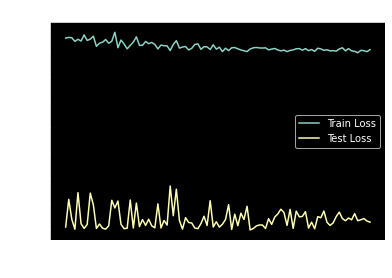

In [18]:
plt.plot(loss[0], label="Train Loss")
plt.plot(loss[1], label="Test Loss")

plt.title("Training")
plt.xlabel("Epoch")
plt.ylabel("Loss")

plt.legend();

In [17]:
loss

(tensor([0.6762, 0.6775, 0.6768, 0.6697, 0.6738, 0.6704, 0.6824, 0.6715, 0.6741,
         0.6799, 0.6598, 0.6661, 0.6679, 0.6733, 0.6660, 0.6699, 0.6877, 0.6572,
         0.6724, 0.6645, 0.6549, 0.6617, 0.6683, 0.6785, 0.6618, 0.6619, 0.6695,
         0.6652, 0.6675, 0.6636, 0.6549, 0.6623, 0.6611, 0.6608, 0.6515, 0.6635,
         0.6711, 0.6564, 0.6585, 0.6595, 0.6528, 0.6559, 0.6636, 0.6648, 0.6540,
         0.6591, 0.6588, 0.6535, 0.6629, 0.6543, 0.6582, 0.6495, 0.6562, 0.6515,
         0.6570, 0.6575, 0.6549, 0.6527, 0.6511, 0.6496, 0.6545, 0.6569, 0.6576,
         0.6567, 0.6565, 0.6569, 0.6528, 0.6544, 0.6557, 0.6527, 0.6509, 0.6524,
         0.6495, 0.6518, 0.6529, 0.6551, 0.6554, 0.6523, 0.6554, 0.6514, 0.6535,
         0.6500, 0.6561, 0.6548, 0.6520, 0.6531, 0.6509, 0.6513, 0.6504, 0.6547,
         0.6571, 0.6510, 0.6553, 0.6509, 0.6499, 0.6471, 0.6519, 0.6513, 0.6494,
         0.6534]),
 tensor([0.3030, 0.3575, 0.3180, 0.2987, 0.3708, 0.3095, 0.3002, 0.3080, 0.3698,
         

### Plots

In [19]:
def plot_stock_prices(data_train, data_test, title='train'):
    
    data_train = data_train.sort_values('initial_stock_price')
    data_test = data_test.sort_values('initial_stock_price')
    fig, axs = plt.subplots(1, 2, figsize=(10, 4), gridspec_kw={'width_ratios': [1, 1]})
    axs[0].scatter(data_train['initial_stock_price'], data_train['option_price'], s=4, c='b', 
                label='Monte-Carlo')
    axs[0].scatter(data_train['initial_stock_price'], data_train['predicted_option_price'], s=4, c='r',
                label='Model')
    axs[0].set_title('Train')
    axs[1].scatter(data_test['initial_stock_price'], data_test['option_price'], s=4, c='b', 
                label='Monte-Carlo')
    axs[1].scatter(data_test['initial_stock_price'], data_test['predicted_option_price'], s=4, c='r',
                label='Model')
    axs[1].set_title('Test')
    for ax in axs.flat:
        ax.set(xlabel='initial stock price', ylabel='option price')
        ax.label_outer()
    plt.savefig(title+'.png', facecolor='white', dpi=150)

    
def plot_loss(loss, title='train'):
    
    train_loss, test_loss = loss[0], loss[1]
    epochs = [i for i in range(len(train_loss))]
    fig, axs = plt.subplots(1, 2, figsize=(10, 4), gridspec_kw={'width_ratios': [1, 1]})
    axs[0].plot(epochs, train_loss, c='b')
    axs[0].set_title('Train')
    axs[1].plot(epochs, test_loss, c='b')
    axs[1].set_title('Test')
    for ax in axs.flat:
        ax.set(xlabel='epoch', ylabel='loss')
        ax.label_outer()
    plt.savefig(title+'.png', facecolor='white', dpi=150)

In [22]:
# plot_loss(loss, 'hybrid_nn_dqc_loss')

In [23]:
# plot_stock_prices(data_train, data_test, title='hybrid_nn_dqc')